In [21]:
import torch
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPool2D, Dropout,Flatten, Conv1D, MaxPool1D, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split

import time
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import math
import matplotlib.pyplot as plt
import json
import math


In [22]:
SEED = 13
tf.random.set_seed(SEED)

In [23]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [24]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [25]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SD\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [26]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
#file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']
file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [27]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217324 entries, 0 to 217323
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      217324 non-null  float64
 1   l_ph_ank      217324 non-null  float64
 2   l_ph_fo       217324 non-null  float64
 3   r_ph_hip      217324 non-null  float64
 4   r_ph_ank      217324 non-null  float64
 5   r_ph_fo       217324 non-null  float64
 6   n_lgrf        217324 non-null  float64
 7   n_r_grf       217324 non-null  float64
 8   n_lcop        217324 non-null  float64
 9   n_rcop        217324 non-null  float64
 10  perc_new      217324 non-null  float64
 11  st_sw_phase   217324 non-null  int64  
 12  strike_frame  217324 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 21.6 MB


In [28]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

l_ph_hip  l_ph_ank   l_ph_fo  r_ph_hip  r_ph_ank   r_ph_fo    n_lgrf  \
0       0.704763  0.704007  0.189543  0.996669  0.845759  0.715530  0.793753   
1       0.700420  0.708872  0.181955  0.996578  0.835557  0.714003  0.790146   
2       0.695302  0.712774  0.172097  0.996360  0.827546  0.712072  0.785954   
3       0.689154  0.715918  0.158854  0.995979  0.821171  0.709687  0.781163   
4       0.681610  0.718457  0.140386  0.995402  0.816049  0.706774  0.775733   
...          ...       ...       ...       ...       ...       ...       ...   
216105  0.657521  0.692187  0.201755  0.919467  0.126418  0.735422  0.695157   
216106  0.651101  0.697047  0.194841  0.914877  0.094520  0.735862  0.696211   
216107  0.643434  0.701224  0.185610  0.910466  0.053127  0.735928  0.697256   
216108  0.634118  0.704811  0.172670  0.906214  0.004952  0.735715  0.698210   
216109  0.622613  0.707886  0.153406  0.902103  0.957602  0.735281  0.698916   

         n_r_grf    n_lcop    n_rcop   perc_new  st_sw_phase  strike_frame  
0       0.044018  0.102021  0.000371   0.000000            0             1  
1       0.057622  0.103377  0.000697   0.404858            0             2  
2       0.072398  0.104737  0.001085   0.809717            0             3  
3       0.087859  0.106096  0.001539   1.214575            0             4  
4       0.103475  0.107448  0.002063   1.619433            0             5  
...          ...       ...       ...        ...          ...           ...  
216105  0.000000  0.098972 -0.000423  97.402597            0           226  
216106  0.000000  0.099974 -0.000422  97.835498            0           227  
216107  0.000000  0.100971 -0.000409  98.268398            0           228  
216108  0.010965  0.101960 -0.000382  98.701299            0           229  
216109  0.020164  0.102935 -0.000338  99.134199            0           230  

[216110 rows x 13 columns]

In [29]:
source_table = source_table.drop(["n_lgrf","n_r_grf", "l_ph_ank", "r_ph_ank", "l_ph_fo", "r_ph_fo", "l_ph_hip", "n_lcop"], axis = 1)
source_table

r_ph_hip    n_rcop   perc_new  st_sw_phase  strike_frame
0       0.996669  0.000371   0.000000            0             1
1       0.996578  0.000697   0.404858            0             2
2       0.996360  0.001085   0.809717            0             3
3       0.995979  0.001539   1.214575            0             4
4       0.995402  0.002063   1.619433            0             5
...          ...       ...        ...          ...           ...
216105  0.919467 -0.000423  97.402597            0           226
216106  0.914877 -0.000422  97.835498            0           227
216107  0.910466 -0.000409  98.268398            0           228
216108  0.906214 -0.000382  98.701299            0           229
216109  0.902103 -0.000338  99.134199            0           230

[216110 rows x 5 columns]

In [30]:
source_table.info()
source_table.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216110 entries, 0 to 216109
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   r_ph_hip      216110 non-null  float64
 1   n_rcop        216110 non-null  float64
 2   perc_new      216110 non-null  float64
 3   st_sw_phase   216110 non-null  int64  
 4   strike_frame  216110 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 8.2 MB


count        mean        std       min        25%  \
r_ph_hip      216110.0    0.556437   0.314763  0.000008   0.232721   
n_rcop        216110.0    0.029481   0.030462 -0.003407   0.000037   
perc_new      216110.0   49.541241  28.731299  0.000000  24.651163   
st_sw_phase   216110.0    0.505631   0.499969  0.000000   0.000000   
strike_frame  216110.0  108.603299  63.497420  1.000000  54.000000   

                     50%         75%         max  
r_ph_hip        0.718786    0.806002    1.000000  
n_rcop          0.022581    0.054251    0.103847  
perc_new       49.523810   74.418605   99.557522  
st_sw_phase     1.000000    1.000000    1.000000  
strike_frame  108.000000  161.000000  287.000000

In [31]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [32]:
#x = x.drop(['r_ph_foot'], axis=1)
#x = x.drop(['r_ph_hip'], axis=1)

In [33]:
data_y = y.values.reshape(-1,2)

In [34]:
type(data_y)

numpy.ndarray

In [35]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [36]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(162071, 10, 4)
(162071, 2)
(54017, 10, 4)
(54017, 2)


In [37]:
print(train_x.shape)
print(validation_x.shape)

(162071, 10, 4)
(54017, 10, 4)


In [38]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        curLR = optimizer.lr
        return curLR
    return lr

In [39]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [98]:
import tensorflow.keras.layers as L
epochs = 30
batch_size = 64                                                                
learning_rate = 1e-2

# learning rate scheduler
use_lr_scheduler = True
lr_factor = 0.5
lr_patience = 8
lr_threshold = 0.01
lr_min_rate = 1e-6


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add((Conv1D(50, kernel_size=2, strides=1,input_shape=(look_back,train_x.shape[2]), activation='relu')))
model.add(MaxPool1D(pool_size=2, strides=1))
model.add(Dropout(0.1))
#model.add(TimeDistributed(Flatten()))
model.add(LSTM(30, return_sequences = True))
model.add(LSTM(10, return_sequences=True))
model.add(attention())
model.add(L.RepeatVector(look_back - 2))
model.add(LSTM(30, return_sequences = True))
model.add(LSTM(10))
model.add(Flatten())
model.add(Dense(2))

#model.build((2,10,10))
#model.build()
print(model.summary())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', get_lr_metric(optimizer), 'mae','mse'])
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 9, 50)             450       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 8, 50)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 8, 50)             0         
                                                                 
 lstm_6 (LSTM)               (None, 8, 30)             9720      
                                                                 
 lstm_7 (LSTM)               (None, 8, 10)             1640      
                                                                 
 attention_3 (attention)     (None, 10)                18        
                                                      

In [99]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

1689/1689 [==============================] - 5s 3ms/step


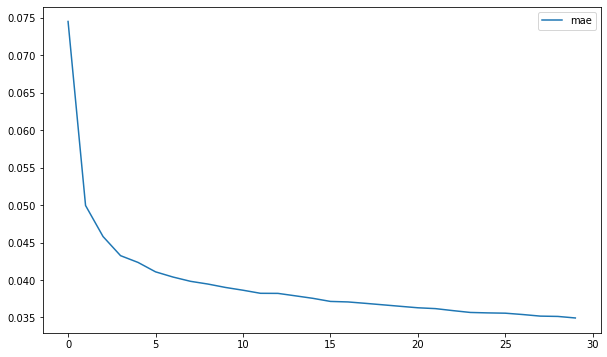

In [100]:

# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
#plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show() 

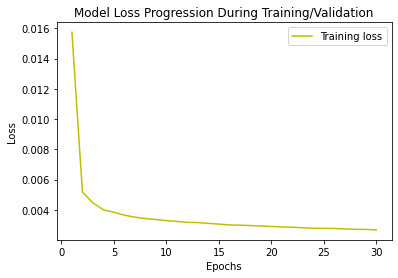

In [101]:
loss= history.history['loss']

epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

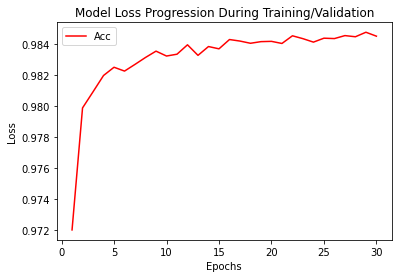

In [102]:

accuracy=history.history['accuracy']
epochs=range(1,len(loss)+1)
plt.plot(epochs,accuracy, 'r', label='Acc')
plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [103]:
validation_x[0].shape

(10, 4)

In [104]:
validation_x.shape
test_data = np.reshape(validation_x[0],(1, validation_x[0].shape[0], validation_x[0].shape[1]))

In [105]:
v = X_test[11:]
v.shape

(54017, 4)

In [106]:
test = model.predict(test_data)
test

1/1 [==============================] - 0s 20ms/step


array([[0.75226444, 0.66336495]], dtype=float32)

In [107]:
trainPredict.shape

(162071, 2)

In [108]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [109]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100

  

  

  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [110]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


In [111]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [112]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

38117
54017
Precision  1 :  70.56482218560824
49997
54017
Precision  2 :  92.5578984393802
52869
54017
Precision  3 :  97.87474313642002
53679
54017
Precision  4 :  99.37427106281356
53899
54017
Precision  5 :  99.78155025269822


In [113]:
# linspace
#rv = multivariate_normal ([0,0],[1,.5],[.5,1])
# Z = rv,pdf(pos)
# contour(x,y,z)

In [114]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  1.1198560023193405


In [115]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

54017
54017
1.1198560023193467


Text(0, 0.5, 'Percentage (%)')

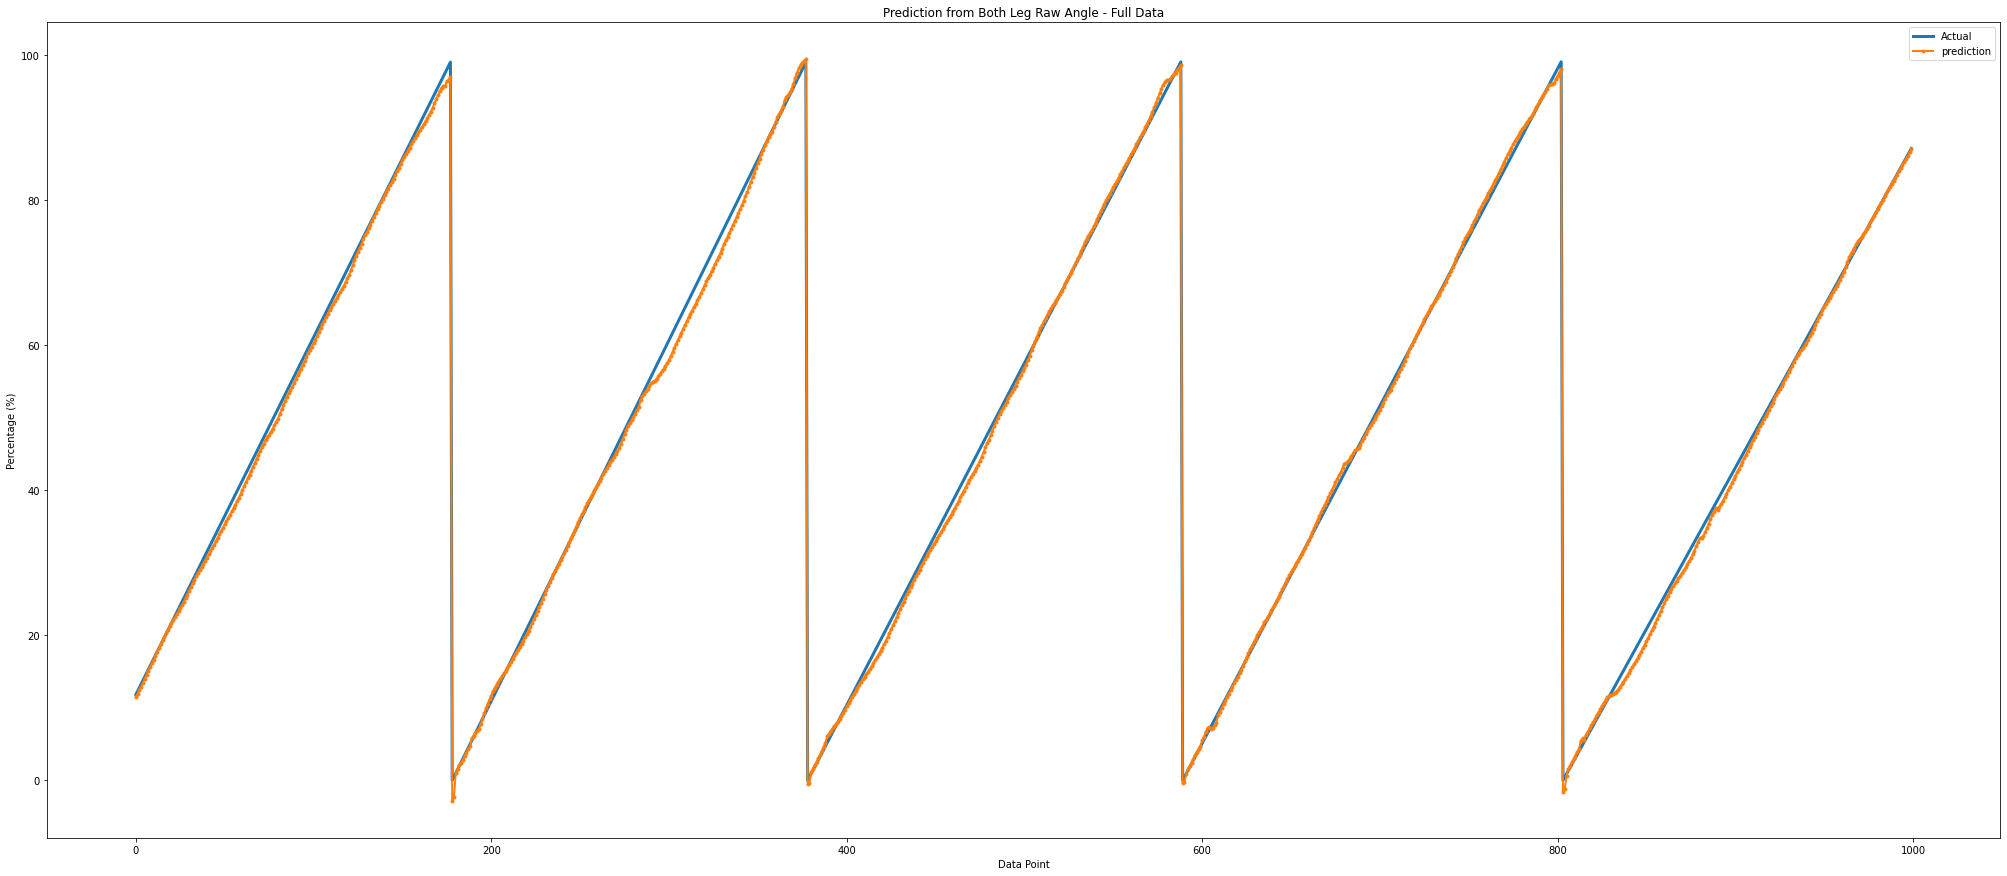

In [116]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual[0:1000],'-',label='Actual', linewidth = 3)
plt.plot(pred[0:1000],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('Prediction from Both Leg Raw Angle - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

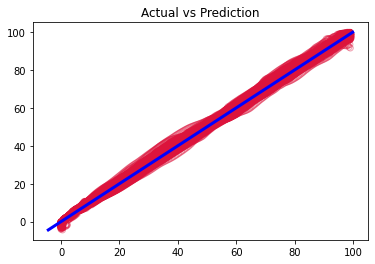

In [117]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [118]:
#predict = np.zeros((len(test_new),1))

#for iter in range(len(test_new)):
#  x = test_new[iter][0]
#  y = test_new[iter][1]
#  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


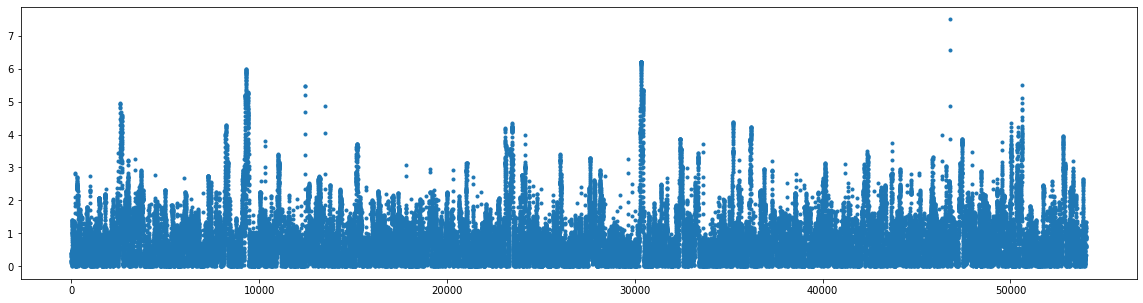

In [119]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')


In [120]:
data_dif = pd.DataFrame(pred)
print(data_dif.to_string())

               0
0      11.501841
1      11.947066
2      12.410837
3      12.907901
4      13.445043
5      14.009087
6      14.568250
7      15.095005
8      15.608585
9      16.120888
10     16.641301
11     17.175211
12     17.722219
13     18.272029
14     18.809153
15     19.326680
16     19.826655
17     20.310167
18     20.777480
19     21.227907
20     21.658839
21     22.068253
22     22.468493
23     22.877178
24     23.296082
25     23.726997
26     24.171751
27     24.632221
28     25.110359
29     25.608148
30     26.122659
31     26.637719
32     27.147714
33     27.644703
34     28.127525
35     28.595142
36     29.045495
37     29.476076
38     29.890342
39     30.305708
40     30.718790
41     31.144593
42     31.586198
43     32.041359
44     32.506541
45     32.980427
46     33.468722
47     33.944250
48     34.408576
49     34.861627
50     35.304925
51     35.755896
52     36.206622
53     36.649704
54     37.087558
55     37.534300
56     37.996222
57     38.4860

In [121]:
act_dif = pd.DataFrame(actual)
print(act_dif.to_string())

               0
0      11.822660
1      12.315271
2      12.807882
3      13.300493
4      13.793103
5      14.285714
6      14.778325
7      15.270936
8      15.763547
9      16.256158
10     16.748768
11     17.241379
12     17.733990
13     18.226601
14     18.719212
15     19.211823
16     19.704433
17     20.197044
18     20.689655
19     21.182266
20     21.674877
21     22.167488
22     22.660099
23     23.152709
24     23.645320
25     24.137931
26     24.630542
27     25.123153
28     25.615764
29     26.108374
30     26.600985
31     27.093596
32     27.586207
33     28.078818
34     28.571429
35     29.064039
36     29.556650
37     30.049261
38     30.541872
39     31.034483
40     31.527094
41     32.019704
42     32.512315
43     33.004926
44     33.497537
45     33.990148
46     34.482759
47     34.975369
48     35.467980
49     35.960591
50     36.453202
51     36.945813
52     37.438424
53     37.931034
54     38.423645
55     38.916256
56     39.408867
57     39.9014

In [122]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

In [123]:
strike = pd.DataFrame(x_test[:,-1])
print(strike.to_string())

           0
0       25.0
1       26.0
2       27.0
3       28.0
4       29.0
5       30.0
6       31.0
7       32.0
8       33.0
9       34.0
10      35.0
11      36.0
12      37.0
13      38.0
14      39.0
15      40.0
16      41.0
17      42.0
18      43.0
19      44.0
20      45.0
21      46.0
22      47.0
23      48.0
24      49.0
25      50.0
26      51.0
27      52.0
28      53.0
29      54.0
30      55.0
31      56.0
32      57.0
33      58.0
34      59.0
35      60.0
36      61.0
37      62.0
38      63.0
39      64.0
40      65.0
41      66.0
42      67.0
43      68.0
44      69.0
45      70.0
46      71.0
47      72.0
48      73.0
49      74.0
50      75.0
51      76.0
52      77.0
53      78.0
54      79.0
55      80.0
56      81.0
57      82.0
58      83.0
59      84.0
60      85.0
61      86.0
62      87.0
63      88.0
64      89.0
65      90.0
66      91.0
67      92.0
68      93.0
69      94.0
70      95.0
71      96.0
72      97.0
73      98.0
74      99.0
75     100.0

In [124]:
x_test[18604][:]

array([2.74437000e-01, 8.07346109e-02, 1.00000000e+00, 1.30000000e+02])

In [125]:
print('Predict: ', pred[18604])
print('Actual: ', actual[18604])

Predict:  [56.50125827]
Actual:  [56.82819383]


In [126]:
dif[18604]

array([0.32693557])